#Libraries

In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader , Dataset , random_split
import lightning as L
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from PIL import Image

#Prepare Dataset & Loaders

In [2]:
train_path = "/project/ai901504-ai0004/kaggle_competition/week5/liver-fibrosis-severity-prediction/train.csv"
test_path = "/project/ai901504-ai0004/kaggle_competition/week5/liver-fibrosis-severity-prediction/test_submission.csv"
image_dir = "/project/ai901504-ai0004/kaggle_competition/week5/liver-fibrosis-severity-prediction/images/images"

In [3]:
train_df = pd.read_csv(train_path)
train_df.head()

,subject,image_name,view,SWE fibrosis stage,TE(kPa),TE result
0,1,5c7e1166e138234adf000b5a,Intercostal,-,3.4,F0
1,2,5c809dc9e138233fae00064d,Intercostal,-,8.5,F2
2,3,5cedf3f5e13823798c000355,Subcostal_hepatic_vein,F2,9.4,F3
3,3,5cedf408e13823798c00035e,Intercostal,F2,9.4,F3
4,3,5cedf40ce13823798c000364,Liver/RK,F2,9.4,F3


In [4]:
test_df = pd.read_csv(test_path)
test_df.head()

,image_name,view,SWE fibrosis stage,TE(kPa)
0,5c7de4d6e138234adf00044d,Intercostal,-,8.8
1,5d118de2e138237034000368,Liver/RK,F0-1,4.3
2,5d1ae0b9e13823585300002f,Intercostal,F0-1,7.5
3,5d1ae0c2e138236ca60005b9,Liver/RK,F0-1,NaN
4,5d1ae0c4e138236ca60005bd,Subcostal_hepatic_vein,F0-1,NaN


In [5]:
class_list = train_df["TE result"].unique().tolist()
print(class_list)

class CustomDataSet(Dataset):
    def __init__(self, csv_file, image_dir,class_list, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.df.image_name[index] + ".png")
        image = Image.open(image_path)
        label = self.df["TE(kPa)"][index]

        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label,dtype = torch.float32)  # Ensure label is a tensor

['F0', 'F2', 'F3', 'F1', 'F4']


In [12]:
BATCH_SIZE = 32
IMAGE_SIZE = 384
MEAN = [0.5,0.5,0.5]
STD = [0.5,0.5,0.5]

# transformation = transforms.Compose([
#         transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=MEAN, std=STD),
#     ])
transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = CustomDataSet(train_path, image_dir,class_list, transform=transformation)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
eval_loader = DataLoader(
    dataset=eval_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

torch.Size([32, 3, 224, 224]) torch.Size([32]) tensor(3.5000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.0125492].


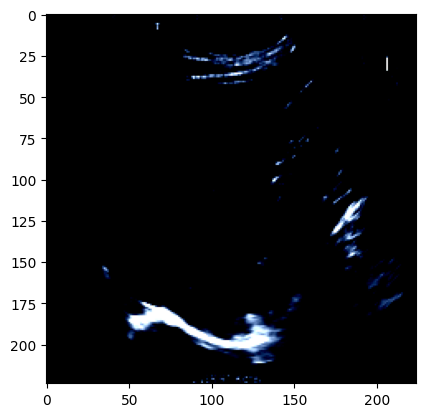

In [13]:
image , label = next(iter(train_loader))
print(image.shape, label.shape,label[0])
imshow(image[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.0125492].


torch.Size([32, 3, 224, 224]) torch.Size([32])


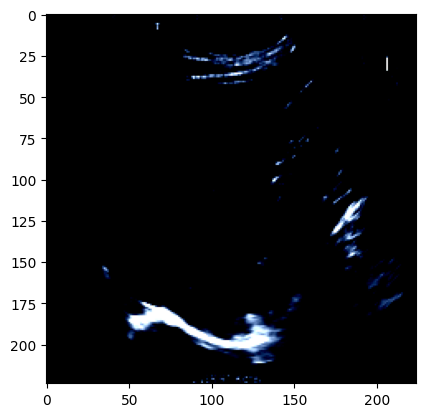

In [14]:
simage , label = next(iter(eval_loader))
print(image.shape, label.shape)
imshow(image[0].permute(1,2,0))

#Define Models

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as L
from torchvision import models

class LiverFibrosisModel(L.LightningModule):
    def __init__(self, num_classes=1):
        super(LiverFibrosisModel, self).__init__()

        # Load pretrained ResNet50
        self.resnet = models.resnet50(weights=None)
        state_dict = torch.load("/project/ai901504-ai0004/507a/resnet50-0676ba61.pth", map_location="cpu")
        self.resnet.load_state_dict(state_dict)
    

        # Replace the final FC layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.resnet(x)
        return self.relu(output)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images).squeeze()
        loss = F.mse_loss(preds, labels.float().squeeze())
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images).squeeze()
        val_loss = F.mse_loss(preds, labels.float().squeeze())
        self.log('val_loss', val_loss, prog_bar=True, on_epoch=True)
        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [15]:
model = LiverFibrosisModel()

In [16]:
trainer = L.Trainer(max_epochs=20,
                    log_every_n_steps = 10)
trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders = eval_loader
            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | resnet | ResNet | 23.5 M
1 | relu   | ReLU   | 0     
----------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [17]:
!nvidia-smi

Wed Jun  4 09:53:04 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   36C    P0    57W / 400W |    553MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
model = LiverFibrosisModel()

trainer = L.Trainer(max_epochs=20,
                    log_every_n_steps = 10)
trainer.fit(model=model,
            train_dataloaders=train_loader,
            val_dataloaders = eval_loader
            )

OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like microsoft/swin-large-patch4-window12-384-in22k is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [18]:
print("Final Train Loss:", trainer.callback_metrics.get("train_loss"))
print("Final Validation Loss:", trainer.callback_metrics.get("val_loss"))

Final Train Loss: tensor(0.4432)
Final Validation Loss: tensor(6.1532)


#Inference

In [19]:
class_list = train_df["TE result"].unique().tolist()
print(class_list)

class CustomDataSetTest(Dataset):
    def __init__(self, csv_file, image_dir,class_list, transform=None):
        self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.df.image_name[index] + ".png")
        image = Image.open(image_path)


        if self.transform:
            image = self.transform(image)
        return image

['F0', 'F2', 'F3', 'F1', 'F4']


In [20]:
test_dataset = CustomDataSetTest(test_path, image_dir,class_list, transform=transformation)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [21]:
predictions = trainer.predict(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [22]:
all_pred = torch.cat(predictions,dim = 0)
pred_array = all_pred.detach().numpy()
len(pred_array)

433

In [18]:
predictions

[tensor([[7.3176],
         [5.7351],
         [4.9908],
         [6.7599],
         [4.7229],
         [5.1922],
         [4.8797],
         [5.3896],
         [5.3365],
         [5.7082],
         [6.8774],
         [4.2651],
         [5.4608],
         [4.7498],
         [6.7014],
         [6.8044],
         [6.2473],
         [6.5048],
         [5.5132],
         [6.0244],
         [4.8890],
         [4.9572],
         [5.9927],
         [4.8684],
         [5.4521],
         [4.8403],
         [4.4335],
         [4.4745],
         [4.4745],
         [4.3343],
         [5.1804],
         [4.4933]]),
 tensor([[ 5.1000],
         [ 4.3026],
         [ 5.5506],
         [ 4.6818],
         [ 6.0769],
         [ 4.8860],
         [ 5.9713],
         [ 6.1267],
         [ 4.7498],
         [ 4.2431],
         [ 4.7177],
         [ 5.5610],
         [ 5.6627],
         [ 5.2850],
         [ 4.3589],
         [ 4.8347],
         [ 4.4838],
         [ 3.9150],
         [ 4.1813],
         [

In [23]:
test_df = pd.read_csv("/project/ai901504-ai0004/kaggle_competition/week5/liver-fibrosis-severity-prediction/test_submission.csv")
test_df.head()

,image_name,view,SWE fibrosis stage,TE(kPa)
0,5c7de4d6e138234adf00044d,Intercostal,-,8.8
1,5d118de2e138237034000368,Liver/RK,F0-1,4.3
2,5d1ae0b9e13823585300002f,Intercostal,F0-1,7.5
3,5d1ae0c2e138236ca60005b9,Liver/RK,F0-1,NaN
4,5d1ae0c4e138236ca60005bd,Subcostal_hepatic_vein,F0-1,NaN


In [27]:
test_df["TE(kPa)"] = pred_array
test_df.head()

,image_name,view,SWE fibrosis stage,TE(kPa)
0,5c7de4d6e138234adf00044d,Intercostal,-,9.070454
1,5d118de2e138237034000368,Liver/RK,F0-1,6.240192
2,5d1ae0b9e13823585300002f,Intercostal,F0-1,6.079818
3,5d1ae0c2e138236ca60005b9,Liver/RK,F0-1,5.947939
4,5d1ae0c4e138236ca60005bd,Subcostal_hepatic_vein,F0-1,4.140749


In [25]:
test = pd.read_csv("/project/ai901504-ai0004/kaggle_competition/week5/liver-fibrosis-severity-prediction/test_submission.csv")
test.head()

,image_name,view,SWE fibrosis stage,TE(kPa)
0,5c7de4d6e138234adf00044d,Intercostal,-,8.8
1,5d118de2e138237034000368,Liver/RK,F0-1,4.3
2,5d1ae0b9e13823585300002f,Intercostal,F0-1,7.5
3,5d1ae0c2e138236ca60005b9,Liver/RK,F0-1,NaN
4,5d1ae0c4e138236ca60005bd,Subcostal_hepatic_vein,F0-1,NaN


In [28]:
test_df.loc[:2, "TE(kPa)"] = test.loc[:2, "TE(kPa)"]
test_df

/tmp/ipykernel_38625/8676099.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.8 4.3 7.5]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  test_df.loc[:2, "TE(kPa)"] = test.loc[:2, "TE(kPa)"]


,image_name,view,SWE fibrosis stage,TE(kPa)
0,5c7de4d6e138234adf00044d,Intercostal,-,8.800000
1,5d118de2e138237034000368,Liver/RK,F0-1,4.300000
2,5d1ae0b9e13823585300002f,Intercostal,F0-1,7.500000
3,5d1ae0c2e138236ca60005b9,Liver/RK,F0-1,5.947939
4,5d1ae0c4e138236ca60005bd,Subcostal_hepatic_vein,F0-1,4.140749
...,...,...,...,...
428,64ba1fdce13823026800003e,Liver/RK,F0-1,6.564017
429,64be2023e1382338cf0015bd,Liver/RK,F0-1,5.898459
430,64bf65f9e138236d58000d31,Subcostal_hepatic_vein,F0-1,5.894130
431,64bf6607e138236d58000d34,Intercostal,F0-1,5.744892


In [29]:
test_df.to_csv("submissionRESNET.csv",index = False)

In [26]:
import plotly.express as px

In [27]:
px.histogram(test_df, x="TE(kPa)",title="ViT Answer Distribution",width=800, height=400)